In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno 

In [2]:
df = pd.read_csv('./cleaned_merged_seasons.csv')  
df.head()

/var/folders/m0/m60fjz952_l28k4w5jsnj12h0000gn/T/ipykernel_1118/3640293773.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./cleaned_merged_seasons.csv')


,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,...,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,...,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,...,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,...,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,...,1.0,0.0,1,0,0,0,45,True,1,1


In [3]:
print(df.columns.tolist())

['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW']


In [4]:
df.shape

(96169, 37)

| Column | Meaning |
|--------|----------|
| **season_x** | The Premier League season (e.g., `2023/24`). |
| **name** | Player’s full name. |
| **position** | Player’s role on the pitch — `GK`, `DEF`, `MID`, or `FWD`. |
| **team_x** | Player’s real-life club (e.g., “Liverpool”). |
| **assists** | Number of assists by the player in that match. |
| **bonus** | Bonus points earned (1–3 points based on the BPS system). |
| **bps** | “Bonus Point System” raw score — used to determine who gets the `bonus` points. |
| **clean_sheets** | 1 if the team conceded **0 goals** while the player was on the pitch (for GKs and DEFs mainly). |
| **creativity** | FPL metric estimating how creative a player was — based on key passes, chances created, etc. |
| **element** | Internal player ID (used in FPL API, not meaningful by itself). |
| **fixture** | Fixture ID — links to which match this row corresponds to. |
| **goals_conceded** | Number of goals conceded by the player’s team during that match (when he was on the field). |
| **goals_scored** | Number of goals the player scored in that match. |
| **ict_index** | FPL composite stat combining **Influence + Creativity + Threat** — an overall activity rating. |
| **influence** | Measures impact on the match (goals, assists, defensive actions, etc.). |
| **kickoff_time** | Date and time of the match kickoff (UTC). |
| **minutes** | Number of minutes the player played in that match. |
| **opponent_team** | ID of the opposing team (numeric). |
| **opp_team_name** | Name of the opposing team (string, more readable). |
| **own_goals** | Number of own goals scored by the player. |
| **penalties_missed** | How many penalties the player missed in that match. |
| **penalties_saved** | For goalkeepers — number of penalties saved. |
| **red_cards** | Number of red cards received in that match (0 or 1). |
| **round** | The gameweek number (1–38). |
| **saves** | For goalkeepers — number of shots saved. |
| **selected** | Number of FPL managers who had selected this player in their teams before that gameweek. |
| **team_a_score** | Goals scored by the **away** team in that fixture. |
| **team_h_score** | Goals scored by the **home** team in that fixture. |
| **threat** | FPL stat measuring how likely a player was to score (based on shots, touches in box, etc.). |
| **total_points** | Player’s total FPL points from that match (main performance indicator). |
| **transfers_balance** | Net transfers (transfers_in − transfers_out) that week. |
| **transfers_in** | How many FPL managers transferred this player **into** their team that week. |
| **transfers_out** | How many FPL managers transferred this player **out** that week. |
| **value** | Player’s FPL price that gameweek (in tenths of a million, e.g. 75 = £7.5M). |
| **was_home** | `True` if the player’s team played **at home**, `False` if **away**. |
| **yellow_cards** | Number of yellow cards received in that match. |
| **GW** | Gameweek label or number (same as `round`, sometimes kept separately). |

In [5]:
isnull = df.isnull().sum()
isnull[isnull>0]

team_x    19852
dtype: int64

In [6]:
df['team_x'].tail(20)

96149       Aston Villa
96150          West Ham
96151             Spurs
96152           Arsenal
96153            Wolves
96154         Brentford
96155           Man Utd
96156           Arsenal
96157            Wolves
96158    Crystal Palace
96159         Leicester
96160           Everton
96161         Leicester
96162             Spurs
96163         Newcastle
96164             Spurs
96165             Spurs
96166       Aston Villa
96167          Brighton
96168       Bournemouth
Name: team_x, dtype: object

In [7]:
teamModeForEachPlayer = df.groupby('name')['team_x'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None)
df['team_x'] = df.apply(lambda row:  teamModeForEachPlayer[row['name']] if pd.isna(row['team_x']) else row['team_x'],axis=1)

In [8]:
isnull = df.isnull().sum()
isnull[isnull>0]

Series([], dtype: int64)

In [14]:
df.duplicated().sum()

np.int64(0)

## Unnecessary columns:


In [16]:
print(df.columns.tolist())

['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes', 'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves', 'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points', 'transfers_balance', 'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards', 'GW']


In [17]:
to_drop_columns = ['season_x', 'season_x','team_x','opponent_team','opp_team_name','transfers_balance', 'transfers_in', 'transfers_out',]

In [ ]:
df = df.sort_values(by=['name', 'GW'])

df['form'] = df.groupby('name')['total_points'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)
df['form'] = df['form']/10

print(df.form)

19852    0.100
44691    0.050
20277    0.300
45255    0.250
20816    0.275
         ...  
41483    0.000
41484    0.000
42382    0.000
42997    0.000
43705    0.000
Name: form, Length: 96169, dtype: float64


## data engineering



In [24]:
df['form'][df.form==0].count()

np.int64(28003)

In [ ]:
pos_summary = (
    df.groupby(['season_x', 'position'])['total_points']
      .sum()
      .reset_index()
)

# Then find average total points per position across seasons
avg_points_by_position = (
    pos_summary.groupby('position')['total_points']
    .mean()
    .sort_values(ascending=False)
)

print(avg_points_by_position)

position
MID    11384.4
DEF     8705.2
FWD     3975.8
GK      2448.8
GKP       72.0
Name: total_points, dtype: float64


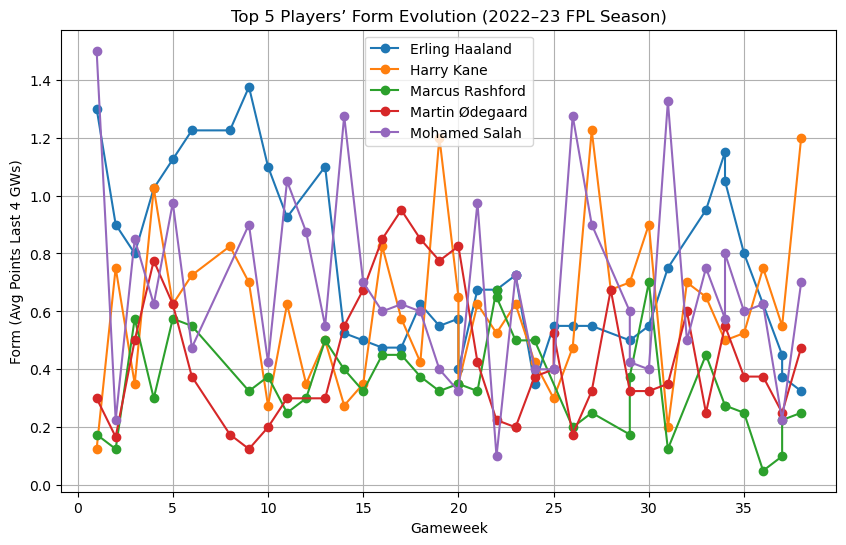

In [37]:
season_2223 = df[df['season_x'] == '2022-23']

top5_players = (
    season_2223.groupby('name')['total_points']
    .sum()
    .nlargest(5)
    .index
)

top5_df = season_2223[season_2223['name'].isin(top5_players)]

plt.figure(figsize=(10,6))
for name, group in top5_df.groupby('name'):
    plt.plot(group['GW'], group['form'], marker='o', label=name)

plt.title('Top 5 Players’ Form Evolution (2022–23 FPL Season)')
plt.xlabel('Gameweek')
plt.ylabel('Form (Avg Points Last 4 GWs)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
latest_gw = season_2223['GW'].max()
top_in_form = (
    season_2223[season_2223['GW'] == latest_gw]
    .nlargest(5, 'form')['name']
)

print("Top 5 players by total points:", list(top5_players))
print("Top 5 players by form in last GW:", list(top_in_form))

Top 5 players by total points: ['Erling Haaland', 'Harry Kane', 'Mohamed Salah', 'Martin Ødegaard', 'Marcus Rashford']
Top 5 players by form in last GW: ['Harry Kane', 'Taiwo Awoniyi', 'Jamie Vardy', 'Andrew Robertson', 'Yoane Wissa']


In [ ]:
df